In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

snow_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/snow_m/*.nc",
              "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/snow_m/*.nc" ]

h2osno_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/h2osno_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/h2osno_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/h2osno_m/*.nc" ]

better_h2osno_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/swe_d/*.nc",
                        "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/swe_d/*.nc" ]

snow_P, snow_H, snow_M = unpacker(snow_paths, "SNOW")
h2osno_P, h2osno_H, h2osno_M = unpacker(h2osno_paths, "H2OSNO")
better_h2osno_P, better_h2osno_H, better_h2osno_M = unpacker(better_h2osno_paths, "H2OSNO")

In [3]:
### Data cleanup
## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Snow
total_snow_P = (snow_P) * seconds_per_year
total_snow_H = (snow_H) * seconds_per_year
total_snow_M = (snow_M) * seconds_per_year

annual_snow_P = total_snow_P.groupby("time.year").mean(dim="time")
annual_snow_H = total_snow_H.groupby("time.year").mean(dim="time")
annual_snow_M = total_snow_M.groupby("time.year").mean(dim="time")

## Snowmelt
# these don't change anything, but I'm leaving it here
# so it makes it easy to mass edit if needed later.
total_h2osno_P = h2osno_P
total_h2osno_H = h2osno_H
total_h2osno_M = h2osno_M

annual_h2osno_P = total_h2osno_P.groupby("time.year").mean(dim="time")
annual_h2osno_H = total_h2osno_H.groupby("time.year").mean(dim="time")
annual_h2osno_M = total_h2osno_M.groupby("time.year").mean(dim="time")

# The model, at best, supports monthly, so this is best that can be done
monthly_h2osno_P = total_h2osno_P.groupby("time.month").mean(dim="time")
monthly_h2osno_H = total_h2osno_H.groupby("time.month").mean(dim="time")
monthly_h2osno_M = total_h2osno_M.groupby("time.month").mean(dim="time")

## Better snowmelt (snow water equivalent)
# In this case, we're just grouping, we have high enough precision where we want individual days
total_better_h2osno_P = better_h2osno_P
total_better_h2osno_H = better_h2osno_H
total_better_h2osno_M = better_h2osno_M

annual_better_h2osno_P = total_better_h2osno_P.groupby("time.year")
annual_better_h2osno_H = total_better_h2osno_H.groupby("time.year")
annual_better_h2osno_M = total_better_h2osno_M.groupby("time.year")

In [4]:
### Helper function: find the maximum point with respect to time
def max_with_time(da):
    idx = int(da.argmax("time"))
    max_val = da.isel(time=idx)
    max_time = da.time[idx].values  
    return xr.Dataset({
        "max_value": max_val,
        "max_time": max_time,
    })

In [5]:
### Helper function: find the (first) minimum point with respect to time
def min_with_time(da):
    idx = int(da.argmin("time"))
    min_val = da.isel(time=idx)
    min_time = da.time[idx].values  
    return xr.Dataset({
        "min_value": min_val,
        "min_time": min_time,
    })

In [6]:
### Data loading: now go get the relevant values for each dataset
def compute_max_result_historic(ds):
    return ds.mean(dim=["lat", "lon"]).groupby("time.year").map(max_with_time).sel(year=slice(1990, 2020))

def compute_max_result_future(ds):
    return ds.mean(dim=["lat", "lon"]).groupby("time.year").map(max_with_time).sel(year=slice(2034, 2064))

def compute_min_result_historic(ds):
    return ds.mean(dim=["lat", "lon"]).groupby("time.year").map(min_with_time).sel(year=slice(1990, 2020))

def compute_min_result_future(ds):
    return ds.mean(dim=["lat", "lon"]).groupby("time.year").map(min_with_time).sel(year=slice(2034, 2064))

#max_result_P = cache_xarray(compute_max_result_historic, total_better_h2osno_P, name_hint="max_result_P")
#max_result_H = cache_xarray(compute_max_result_future, total_better_h2osno_H, name_hint="max_result_H")
#max_result_M = cache_xarray(compute_max_result_future, total_better_h2osno_M, name_hint="max_result_M")

#min_result_P = cache_xarray(compute_min_result_historic, total_better_h2osno_P, name_hint="min_result_P")
#min_result_H = cache_xarray(compute_min_result_future, total_better_h2osno_H, name_hint="min_result_H")
#min_result_M = cache_xarray(compute_min_result_future, total_better_h2osno_M, name_hint="min_result_M")

max_result_P = total_better_h2osno_P.mean(dim=["lat", "lon"]).groupby("time.year").map(max_with_time).sel(year=slice(1990, 2020))
max_result_H = total_better_h2osno_H.mean(dim=["lat", "lon"]).groupby("time.year").map(max_with_time).sel(year=slice(2034, 2064))
max_result_M = total_better_h2osno_M.mean(dim=["lat", "lon"]).groupby("time.year").map(max_with_time).sel(year=slice(2034, 2064))

min_result_P = total_better_h2osno_P.mean(dim=["lat", "lon"]).groupby("time.year").map(min_with_time).sel(year=slice(1990, 2020))
min_result_H = total_better_h2osno_H.mean(dim=["lat", "lon"]).groupby("time.year").map(min_with_time).sel(year=slice(2034, 2064))
min_result_M = total_better_h2osno_M.mean(dim=["lat", "lon"]).groupby("time.year").map(min_with_time).sel(year=slice(2034, 2064))

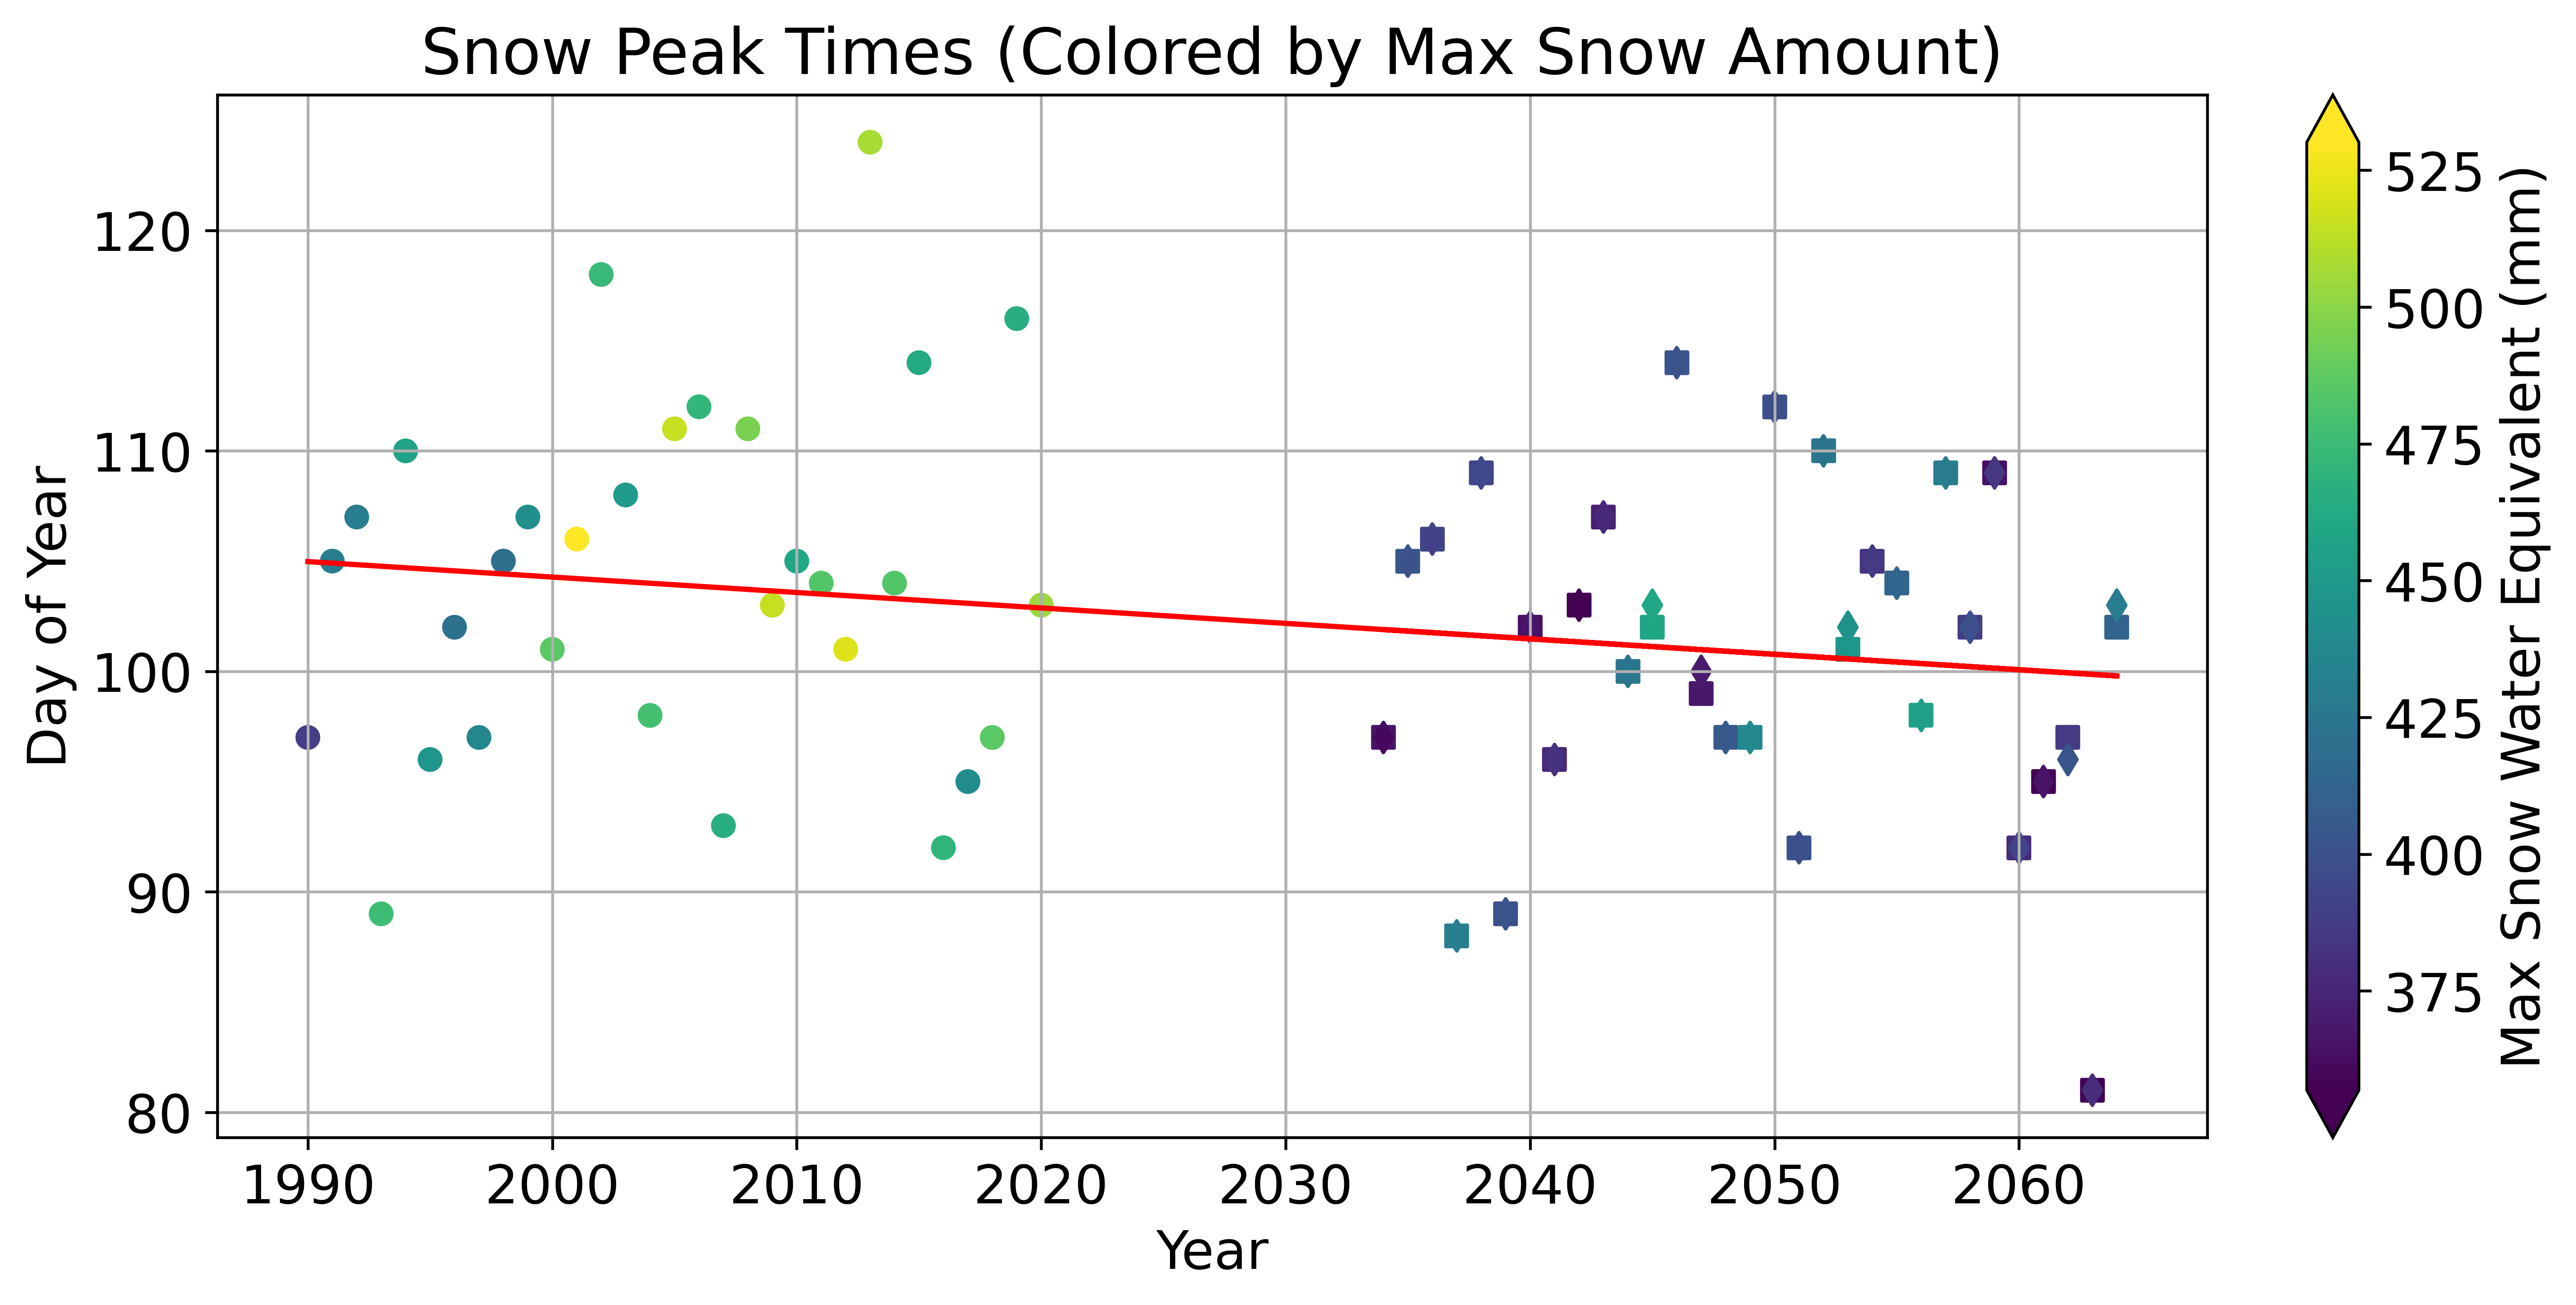

In [7]:
### Data visualization: snow melt times colored by max SWE (bad graph)
years_P = max_result_P.year.values
doys_P = pd.to_datetime(max_result_P.max_time.values).dayofyear
intensity_P = max_result_P.max_value.values

years_H = max_result_H.year.values
doys_H = pd.to_datetime(max_result_H.max_time.values).dayofyear
intensity_H = max_result_H.max_value.values

years_M = max_result_M.year.values
doys_M = pd.to_datetime(max_result_M.max_time.values).dayofyear
intensity_M = max_result_M.max_value.values

all_vals = np.concatenate([
    max_result_P.max_value.values,
    max_result_H.max_value.values,
    max_result_M.max_value.values
])

all_years = np.concatenate([
    max_result_P.year.values,
    max_result_H.year.values,
    max_result_M.year.values
])

all_doys = np.concatenate([
    pd.to_datetime(max_result_P.max_time.values).dayofyear,
    pd.to_datetime(max_result_H.max_time.values).dayofyear,
    pd.to_datetime(max_result_M.max_time.values).dayofyear
])

# needed for accurate colorbars
vmin, vmax = all_vals.min(), all_vals.max()

plt.rc('font', size=15)
plt.figure(figsize=(10, 5), dpi=600, constrained_layout=True)
sc1 = plt.scatter(years_P, doys_P, c=intensity_P, vmin=vmin, vmax=vmax, cmap="viridis", marker='o')
sc2 = plt.scatter(years_H, doys_H, c=intensity_H, vmin=vmin, vmax=vmax, cmap="viridis", marker='s')
sc3 = plt.scatter(years_M, doys_M, c=intensity_M, vmin=vmin, vmax=vmax, cmap="viridis", marker='d')

slope, intercept = np.polyfit(all_years, all_doys, 1)
line = slope * all_years + intercept
# line of best fit
plt.plot(all_years, line, color='red')

plt.xlabel("Year")
plt.ylabel("Day of Year")
plt.title("Snow Peak Times (Colored by Max Snow Amount)")
plt.colorbar(sc1, label="Max Snow Water Equivalent (mm)", extend="both")
plt.grid(True)

## saving this work to disk
os.makedirs("snow_peak_times", exist_ok=True)
plt.savefig(f"snow_peak_times/plot-max-timing.png")

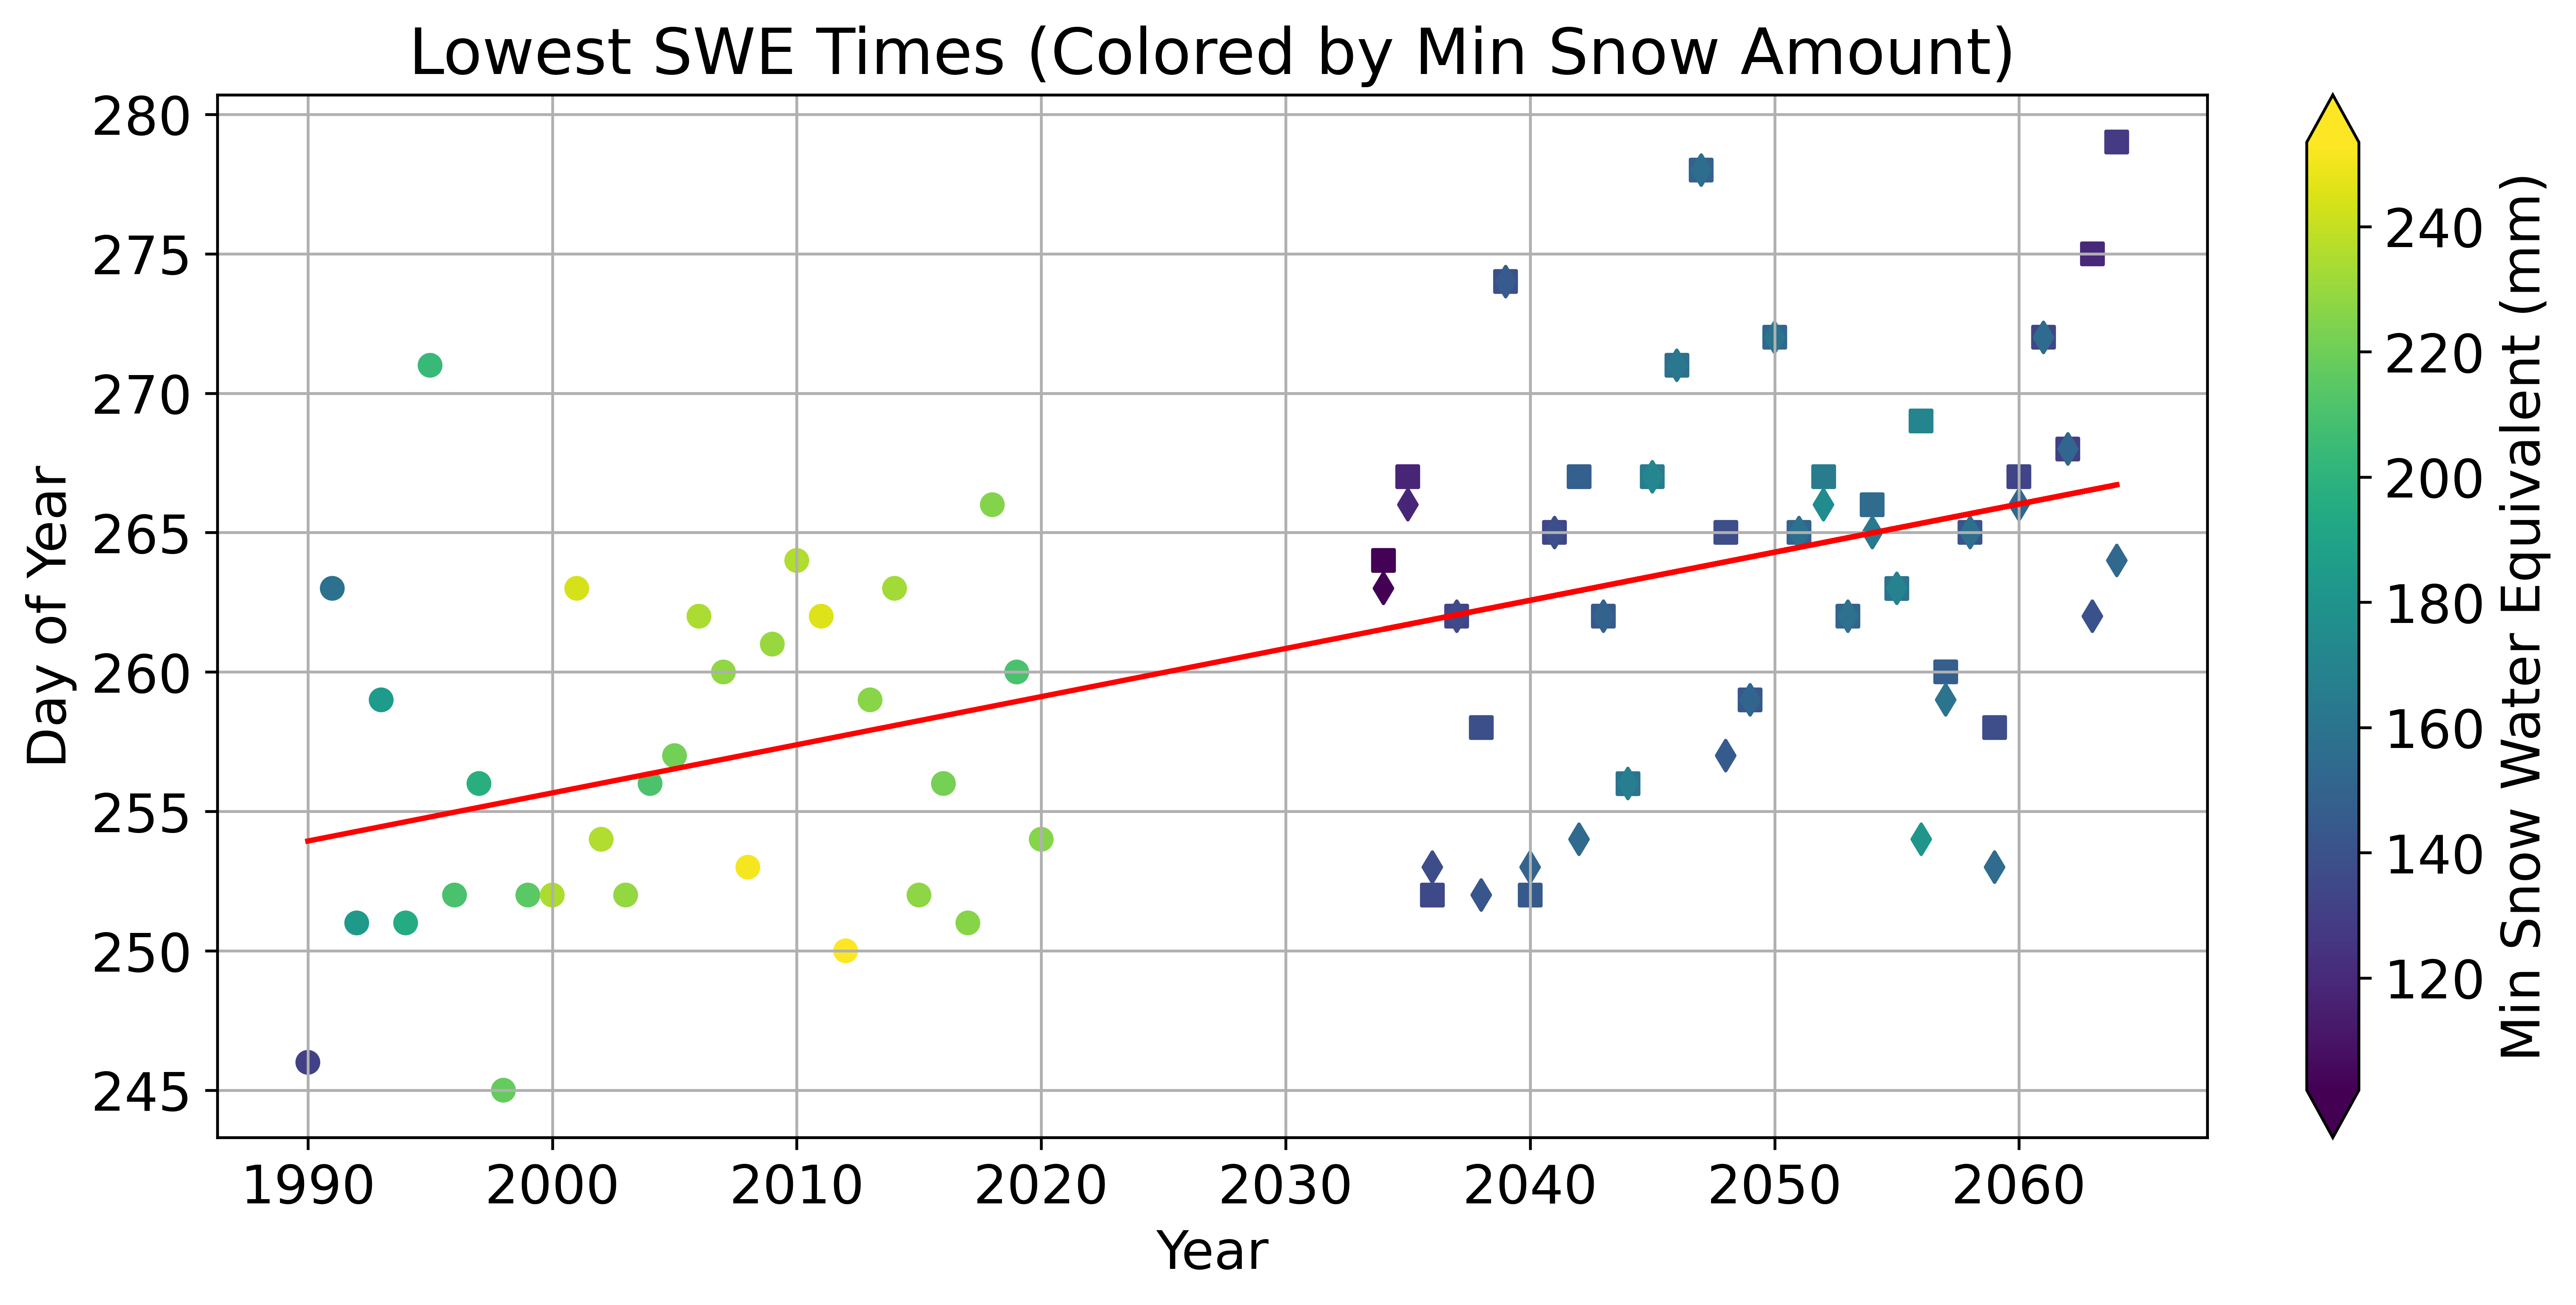

In [8]:
### Data visualization: first zero snowfall times colored by min SWE (bad graph)
years_P = min_result_P.year.values
doys_P = pd.to_datetime(min_result_P.min_time.values).dayofyear
intensity_P = min_result_P.min_value.values

years_H = min_result_H.year.values
doys_H = pd.to_datetime(min_result_H.min_time.values).dayofyear
intensity_H = min_result_H.min_value.values

years_M = min_result_M.year.values
doys_M = pd.to_datetime(min_result_M.min_time.values).dayofyear
intensity_M = min_result_M.min_value.values

all_vals = np.concatenate([
    min_result_P.min_value.values,
    min_result_H.min_value.values,
    min_result_M.min_value.values
])

all_years = np.concatenate([
    min_result_P.year.values,
    min_result_H.year.values,
    min_result_M.year.values
])

all_doys = np.concatenate([
    pd.to_datetime(min_result_P.min_time.values).dayofyear,
    pd.to_datetime(min_result_H.min_time.values).dayofyear,
    pd.to_datetime(min_result_M.min_time.values).dayofyear
])

# needed for accurate colorbars
vmin, vmax = all_vals.min(), all_vals.max()

plt.rc('font', size=15)
plt.figure(figsize=(10, 5), dpi=600, constrained_layout=True)
sc1 = plt.scatter(years_P, doys_P, c=intensity_P, vmin=vmin, vmax=vmax, cmap="viridis", marker='o')
sc2 = plt.scatter(years_H, doys_H, c=intensity_H, vmin=vmin, vmax=vmax, cmap="viridis", marker='s')
sc3 = plt.scatter(years_M, doys_M, c=intensity_M, vmin=vmin, vmax=vmax, cmap="viridis", marker='d')

slope, intercept = np.polyfit(all_years, all_doys, 1)
line = slope * all_years + intercept
# line of best fit
plt.plot(all_years, line, color='red')

plt.xlabel("Year")
plt.ylabel("Day of Year")
plt.title("Lowest SWE Times (Colored by Min Snow Amount)")
plt.colorbar(sc1, label="Min Snow Water Equivalent (mm)", extend="both")
plt.grid(True)

## saving this work to disk
os.makedirs("snow_peak_times", exist_ok=True)
plt.savefig(f"snow_peak_times/plot-min-timing.png")

In [9]:
### Helper function: add the snow between two maxes (it's not very good)
def add_snow_accum_ratio(mean_swe_1d, max_info):
    years = max_info.year.values
    max_vals = max_info["max_value"].values
    max_times = pd.to_datetime(max_info["max_time"].values)

    ratios = []
    accums = []
    valid_years = []

    for year, max_val, t1 in zip(years, max_vals, max_times):
        if pd.isnull(t1) or max_val == 0:
            continue

        #print(f"year: {year} data was not null")

        # define snow season: Sep 1 (prev year) to max SWE
        start = pd.Timestamp(f"{year - 1}-09-01")
        end = pd.Timestamp(t1)

        segment = mean_swe_1d.sel(time=slice(start, end)).load()
        if segment.size == 0 or segment.max() == 0:
            continue

        #print(f"year: {year} segment was not null")

        # first snow (non-zero SWE)
        positive = segment.where(segment > 0, drop=True)
        if positive.size == 0:
            continue

        #print(f"year: {year} positive segment was not null")

        t0 = pd.Timestamp(positive.time[0].values)
        if t0 > end:
            continue

        #print(f"year: {year} timestamps are sane")

        accum = mean_swe_1d.sel(time=slice(t0, end)).sum()
        ratio = (max_val / accum)

        valid_years.append(year)
        ratios.append(ratio)
        accums.append(accum)
        
        #print(f"year: {year} data appended, success")

    return max_info.sel(year=valid_years).assign({
        "snow_accum_ratio": xr.DataArray(ratios, dims=["year"], coords={"year": valid_years}),
        "snow_accum": xr.DataArray(accums, dims=["year"], coords={"year": valid_years})
    })

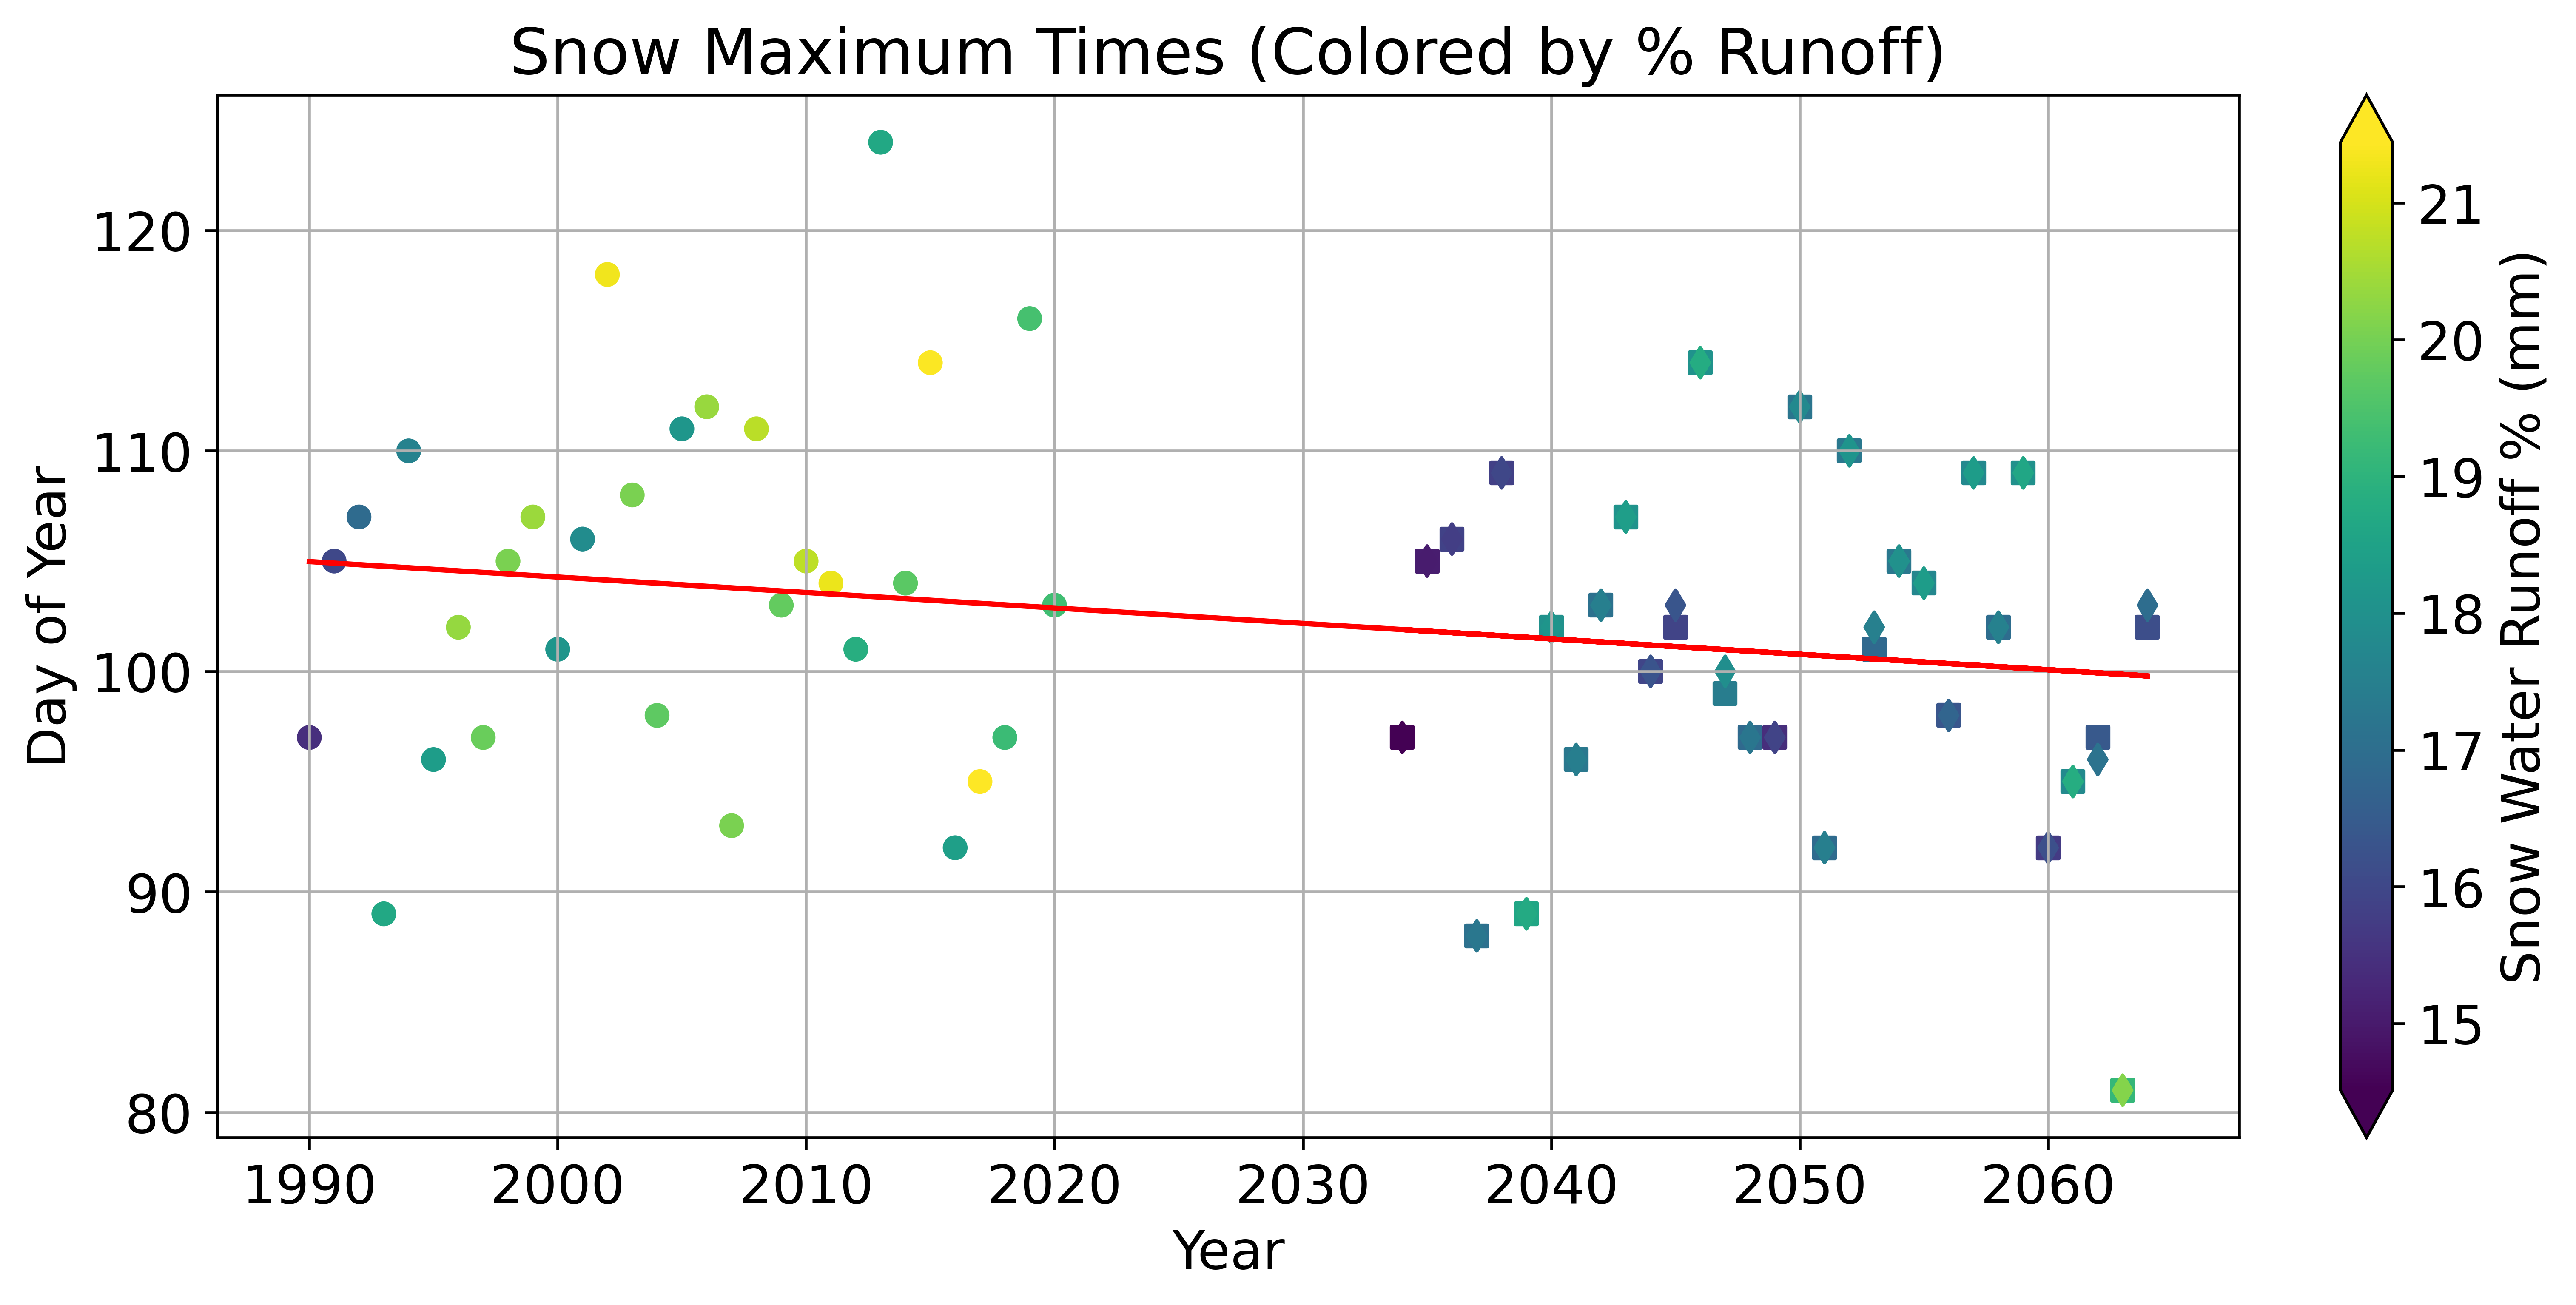

In [10]:
### Data visualization: snow maximum times by % runoff, for the whole state
mean_swe_1d_P = total_better_h2osno_P.mean(dim=["lat", "lon"])
max_info_P = mean_swe_1d_P.groupby("time.year").map(max_with_time).sel(year=slice(1990, 2020))
#complete_data_P = add_snow_accum_ratio(mean_swe_1d_P, max_info_P)
complete_data_P = add_snow_accum_ratio(snow_P, max_info_P)

mean_swe_1d_H = total_better_h2osno_H.mean(dim=["lat", "lon"])
max_info_H = mean_swe_1d_H.groupby("time.year").map(max_with_time).sel(year=slice(2034, 2064))
#complete_data_H = add_snow_accum_ratio(mean_swe_1d_H, max_info_H)
complete_data_H = add_snow_accum_ratio(snow_H, max_info_H)

mean_swe_1d_M = total_better_h2osno_M.mean(dim=["lat", "lon"])
max_info_M = mean_swe_1d_M.groupby("time.year").map(max_with_time).sel(year=slice(2034, 2064))
#complete_data_M = add_snow_accum_ratio(mean_swe_1d_M, max_info_M)
complete_data_M = add_snow_accum_ratio(snow_M, max_info_M)

# It seems we lack the same quality of data in the future?
years_P = complete_data_P.year.values
doys_P = pd.to_datetime(complete_data_P.max_time.values).dayofyear
intensity_P = complete_data_P.snow_accum_ratio.values

years_H = complete_data_H.year.values
doys_H = pd.to_datetime(complete_data_H.max_time.values).dayofyear
intensity_H = complete_data_H.snow_accum_ratio.values

years_M = complete_data_M.year.values
doys_M = pd.to_datetime(complete_data_M.max_time.values).dayofyear
intensity_M = complete_data_M.snow_accum_ratio.values

all_vals = np.concatenate([
    complete_data_P.snow_accum_ratio.values,
    complete_data_H.snow_accum_ratio.values,
    complete_data_M.snow_accum_ratio.values
])

all_years = np.concatenate([
    complete_data_P.year.values,
    complete_data_H.year.values,
    complete_data_M.year.values
])

all_doys = np.concatenate([
    pd.to_datetime(complete_data_P.max_time.values).dayofyear,
    pd.to_datetime(complete_data_H.max_time.values).dayofyear,
    pd.to_datetime(complete_data_M.max_time.values).dayofyear
])

# needed for accurate colorbars
vmin, vmax = all_vals.min(), all_vals.max()

plt.rc('font', size=15)
plt.figure(figsize=(10, 5), dpi=600, constrained_layout=True)
sc1 = plt.scatter(years_P, doys_P, c=intensity_P, vmin=vmin, vmax=vmax, cmap="viridis", marker='o')
sc2 = plt.scatter(years_H, doys_H, c=intensity_H, vmin=vmin, vmax=vmax, cmap="viridis", marker='s')
sc3 = plt.scatter(years_M, doys_M, c=intensity_M, vmin=vmin, vmax=vmax, cmap="viridis", marker='d')

slope, intercept = np.polyfit(all_years, all_doys, 1)
line = slope * all_years + intercept
# line of best fit
plt.plot(all_years, line, color='red')

plt.xlabel("Year")
plt.ylabel("Day of Year")
plt.title("Snow Maximum Times (Colored by % Runoff)")
plt.colorbar(sc1, label="Snow Water Runoff % (mm)", extend="both")
plt.grid(True)

## saving this work to disk
os.makedirs("snow_peak_times", exist_ok=True)
plt.savefig(f"snow_peak_times/plot-broken-maximum-runoff-DONTUSE.png")

In [11]:
total_h2osno_P

<xarray.DataArray 'H2OSNO' (time: 388, lat: 662, lon: 782)> Size: 803MB
dask.array<concatenate, shape=(388, 662, 782), dtype=float32, chunksize=(12, 662, 782), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1989-07-01 1989-08-01 ... 2021-10-01
  * lon      (lon) float32 3kB 184.2 184.3 184.3 184.4 ... 225.7 225.7 225.8
  * lat      (lat) float32 3kB 50.01 50.04 50.07 50.11 ... 69.83 69.86 69.89
Attributes:
    long_name:     snow depth (liquid water)
    units:         mm
    cell_methods:  time: mean